In [1]:
import datetime

from baec.measurements.io.basetime import BaseTimeBucket, Credentials
from baec.measurements.measured_settlement_series import MeasuredSettlementSeries
from baec.measurements.io.zbase import measurements_from_zbase
from baec.measurements.measured_settlement_series import MeasuredSettlementSeries
from baec.model.fitcore import FitCoreModelGenerator2, FitCoreModel, FittingParameters
from baec.measurements.settlement_rod_measurement_series import SettlementRodMeasurementSeries
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

from nuclei.client import NucleiClient

from pprint import pprint


In [2]:
# Get credentials from environment variables
basetime_credentials = Credentials()
cems_nuclei_client = NucleiClient()

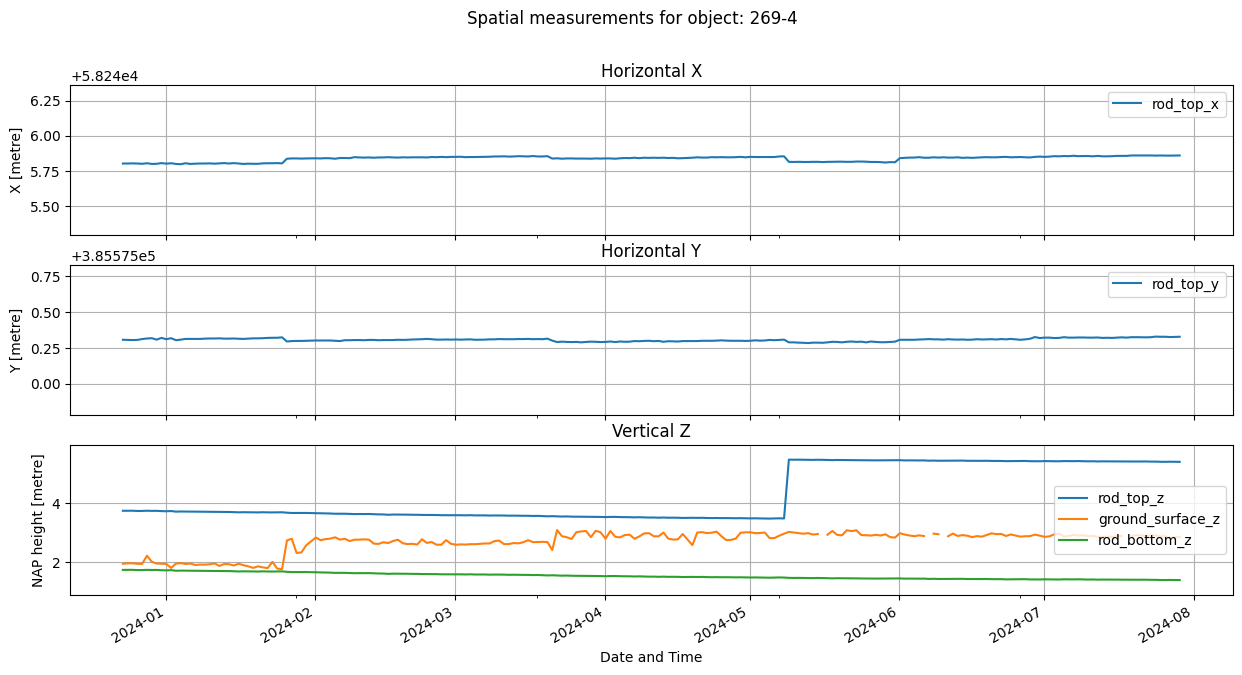

In [3]:
# Create base time bucket to request data to Basetime
basetime_bucket = BaseTimeBucket(
    credentials=basetime_credentials,
    s3bucket="baec",
)

# Request data for a given company, project and rod_id
measurement_series = basetime_bucket.make_settlement_rod_measurement_series(
    company="Demo",
    project="Hansweert",
    rod_id="269-4",
)

# Visualize the measurements
fig = measurement_series.plot_xyz_time()
fig.set_size_inches(15, 7.5)

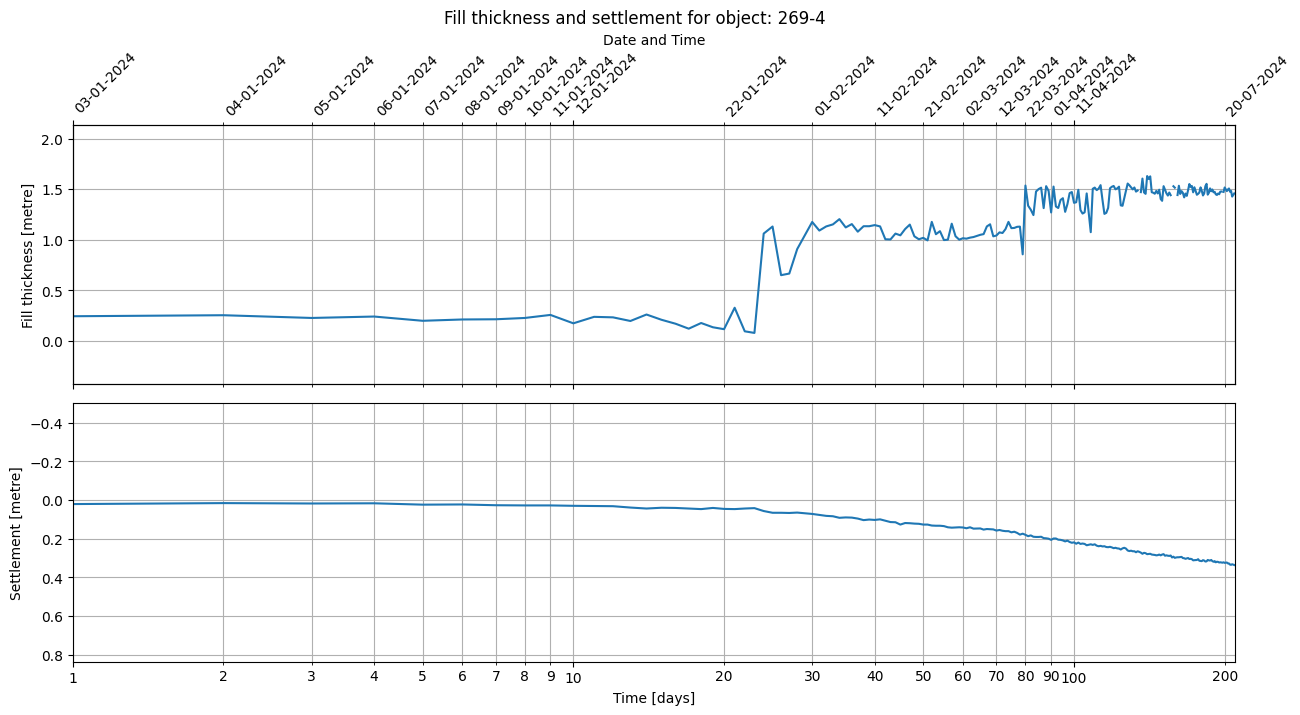

In [4]:
# Create settlement series from measurements
settlement_series = MeasuredSettlementSeries(
    series=measurement_series,
    start_date_time=datetime.datetime(2024, 1, 2),
)

# Visualize the settlements
fig = settlement_series.plot_fill_settlement_time()
fig.set_size_inches(15, 7.5)

#### Fit Model

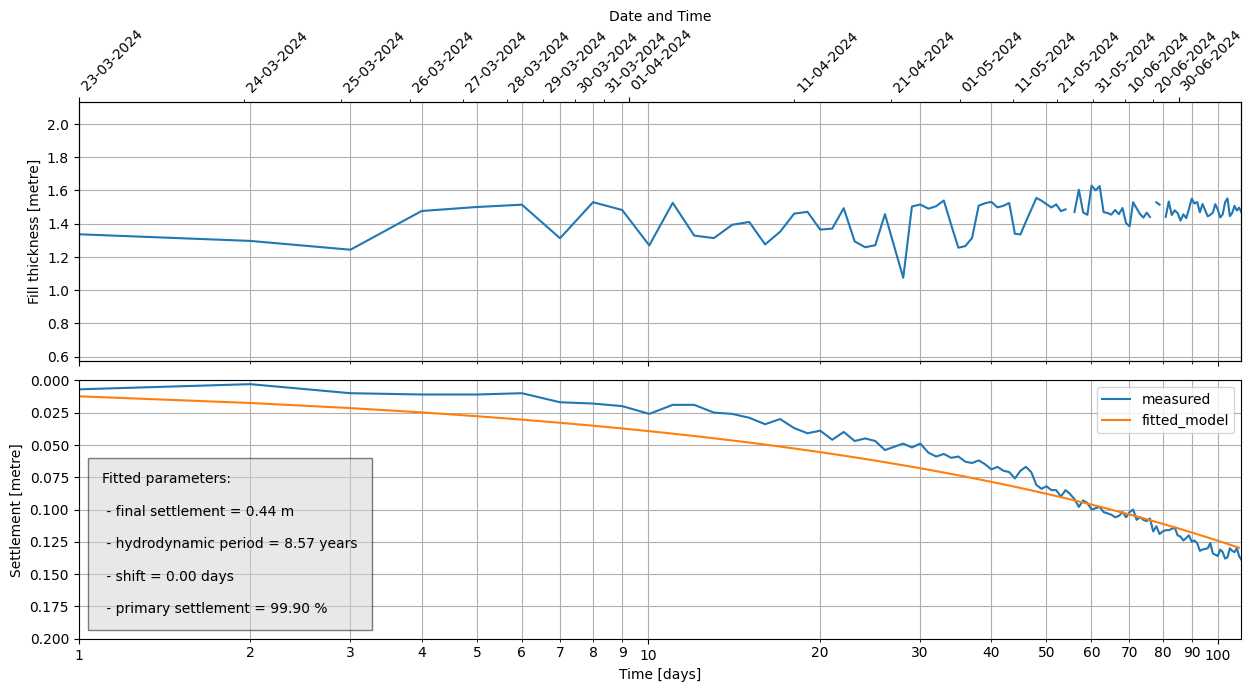

In [5]:
# Create a simple Koppejan model generator. This will be used to fit models.
base_model = FitCoreModel.default()
base_model.primarySettlement = 99.9  # %

model_generator = FitCoreModelGenerator2(
    base_model=base_model,
    fitting_parameters=FittingParameters.all_free_except(["primarySettlement"]),
    client=cems_nuclei_client,
)

# Fit the model to the settlement series
settlement_series.start_date_time = datetime.datetime(2024, 3, 22)
fitted_model = model_generator.fit(settlement_series)

# Predict using the fitted model
end_days = 110.0
fitted_model.predict(end_days_or_datetime=end_days)

# Plot measured vs. fitted model predictions
fig = fitted_model.plot_fill_settlement_time()
fig.axes[1].set_ylim(top=0.0, bottom=0.2)
# for ax in fig.axes:
#     ax.set_xlim(right=end_days)
label = """Fitted parameters:
    \n - final settlement = {:.2f} m
    \n - hydrodynamic period = {:.2f} years
    \n - shift = {:.2f} days
    \n - primary settlement = {:.2f} %""".format(
    fitted_model.model.finalSettlement,
    fitted_model.model.hydrodynamicPeriod,
    fitted_model.model.shift,
    fitted_model.model.primarySettlement,
)
fig.axes[1].text(1.1, 0.18, label, bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 10}, fontsize=10)
fig.set_size_inches(15, 7.5)

#### Fit Model: Animation

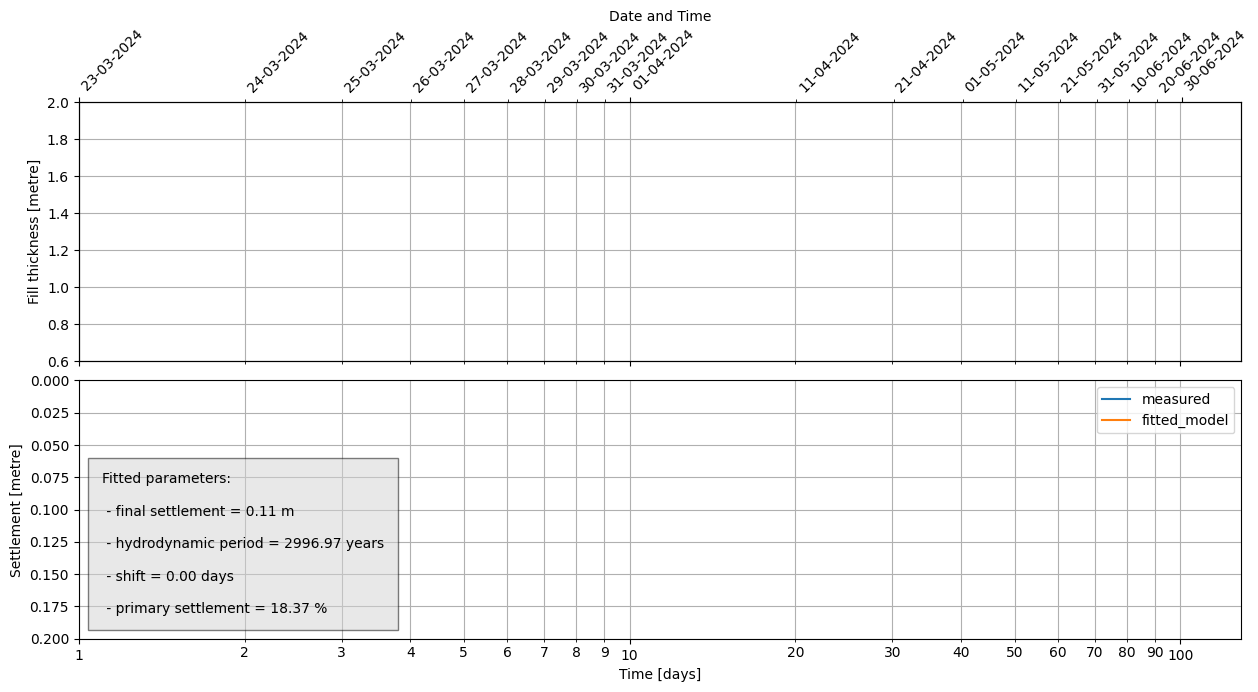

In [10]:
# Create a simple Koppejan model generator. This will be used to fit models.
base_model = FitCoreModel.default()
# base_model.primarySettlement = 99.9  # %

model_generator = FitCoreModelGenerator2(
    base_model=base_model,
    # fitting_parameters=FittingParameters.all_free_except(["primarySettlement"]),
    fitting_parameters=FittingParameters.all_free(),
    client=cems_nuclei_client,
)

# Loop making to make a fit every measurement
start_fitting_index = 110
fit_every = 1 # 10

# Make the figure for the last measuremeent
# Create settlement series from measurements
updated_settlement_series = MeasuredSettlementSeries(
    series=SettlementRodMeasurementSeries(
        measurements=measurement_series.measurements[start_fitting_index:-1]
    ),
    start_date_time=datetime.datetime(2024, 3, 22, hour=2),
)

# Fit the model to the settlement series
fitted_model = model_generator.fit(updated_settlement_series)

# Predict using the fitted model
fitted_model.predict(end_days_or_datetime=measurement_series.measurements[-1].date_time)

# Plot measured vs. fitted model predictions
fig = fitted_model.plot_fill_settlement_time()
fig.axes[0].set_ylim(top=2.0, bottom=0.6)
fig.axes[1].set_ylim(top=0.0, bottom=0.2)
fig.set_size_inches(15, 7.5)

label = """Fitted parameters:
    \n - final settlement = {:.2f} m
    \n - hydrodynamic period = {:.2f} years
    \n - shift = {:.2f} days
    \n - primary settlement = {:.2f} %""".format(
    fitted_model.model.finalSettlement,
    fitted_model.model.hydrodynamicPeriod,
    fitted_model.model.shift,
    fitted_model.model.primarySettlement,
)
fig.axes[1].text(1.1, 0.18, label, bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 10}, fontsize=10)
fig.set_size_inches(15, 7.5)

def update(i_frame):
    
    i = start_fitting_index + fit_every * (i_frame + 1)
    
    # Create settlement series from measurements
    updated_settlement_series = MeasuredSettlementSeries(
        series=SettlementRodMeasurementSeries(
            measurements=measurement_series.measurements[start_fitting_index:i+1]
        ),
        start_date_time=datetime.datetime(2024, 3, 22, hour=2),
    )

    # Fit the model to the settlement series
    fitted_model = model_generator.fit(updated_settlement_series)

    # Predict using the fitted model
    fitted_model.predict(end_days_or_datetime=measurement_series.measurements[i].date_time)

    # Update measured fill thicknesses 
    fig.axes[0].lines[0].set_xdata(updated_settlement_series.days)
    fig.axes[0].lines[0].set_ydata(updated_settlement_series.fill_thicknesses)
    
    # Update measured settlements
    fig.axes[1].lines[0].set_xdata(updated_settlement_series.days)
    fig.axes[1].lines[0].set_ydata(updated_settlement_series.settlements)
    
    # Update fitted settlements
    fig.axes[1].lines[1].set_xdata(fitted_model.predicted_settlements.days)
    fig.axes[1].lines[1].set_ydata(fitted_model.predicted_settlements.settlement)
    
    # Update fitted parameters label
    label = """Fitted parameters:
        \n - final settlement = {:.2f} m
        \n - hydrodynamic period = {:.2f} years
        \n - shift = {:.2f} days
        \n - primary settlement = {:.2f} %""".format(
        fitted_model.model.finalSettlement,
        fitted_model.model.hydrodynamicPeriod,
        fitted_model.model.shift,
        fitted_model.model.primarySettlement,
    )
    fig.axes[1].texts[0].set_text(label)

animation = FuncAnimation(fig=fig, func=update, frames=len(range(start_fitting_index + 1, len(measurement_series.measurements), fit_every)) - 1, repeat=True)

# To save the animation using Pillow as a gif
writer = PillowWriter(fps=15, metadata=dict(artist='Me'), bitrate=1800)
animation.save('test.gif', writer=writer)
